In [1]:
import torch 
import copy
import json 
from omegaconf import DictConfig, OmegaConf 
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 
from utils_pdhg import *


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw_warm_start",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pd_adamw_warm_start and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.01, pdhg_iters=100, warm_start=True
    momentum=False, diag_scaling=True, accel=False, pd_type='pdhg', halpern_start=5, reflected_pdhg=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 9.702117919921875
In rank: 0, time taken for epoch 1 :  1

In [3]:
with initialize(config_path="../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw_warm_start/bs-4-lr-0.001-wd-0/attn_pd_adamw_warm_start-lr-0.001-constant-linear-347f2b8d240711ecbb4b6233ec09013f.json


iteration=0
  layer   W_q_norm   W_k_norm  G_q_norm  G_k_norm    Y_norm
0     0  81.372963  79.388237  0.013209  0.013600  0.610949
1     1  79.773788  76.225471  0.003659  0.003802  0.586982
2     2  70.044914  73.106255  0.001973  0.002151  0.544671
3     3  70.250366  81.655289  0.001705  0.001678  0.622076


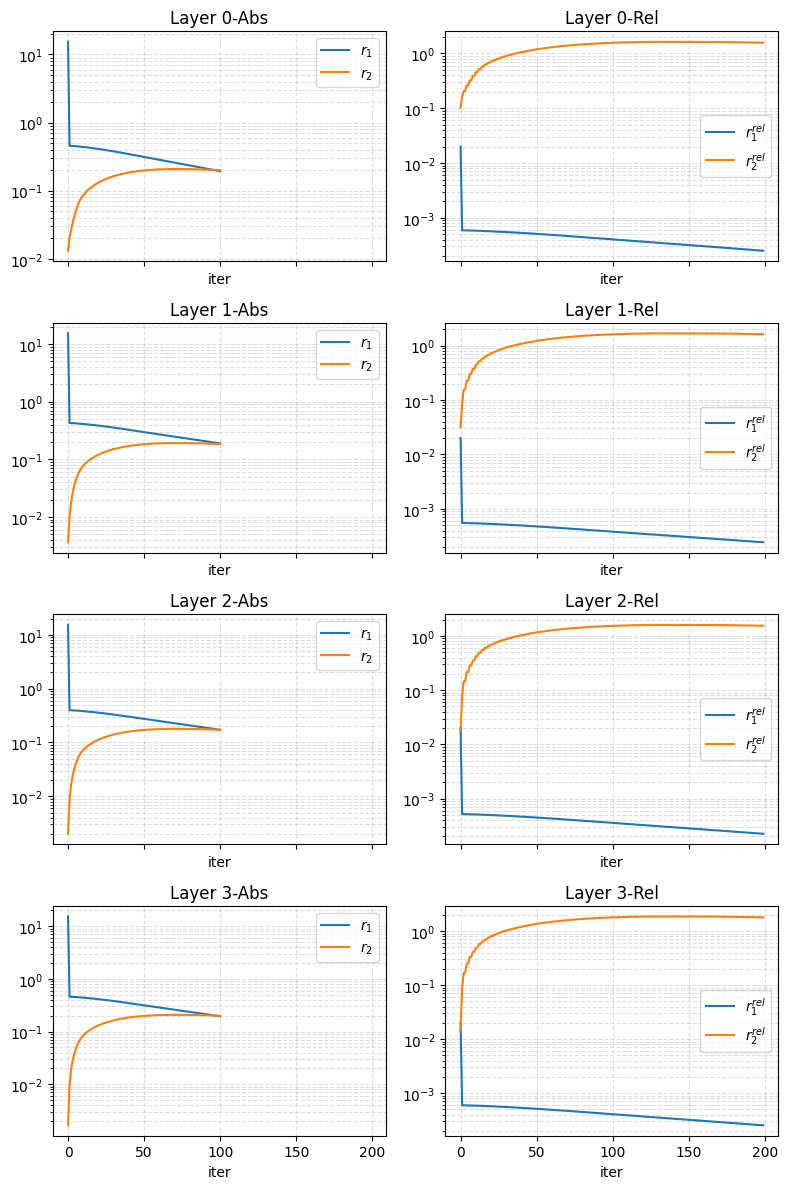

In [4]:
it = 0
print(f"iteration={it}")
import pandas as pd
it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], 
        # "dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)

plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=50
  layer      W_q_norm      W_k_norm      G_q_norm      G_k_norm    Y_norm
0     0    306.458923     68.795822  5.654153e-02  7.019596e-01  0.725902
1     1  12256.115234   6687.586426  1.002820e-04  6.451163e-03  1.050258
2     2  20509.929688  16178.931641  4.117533e-09  1.711902e-06  0.795575
3     3  10017.278320  16458.917969  2.726049e-10  3.818942e-09  0.172277


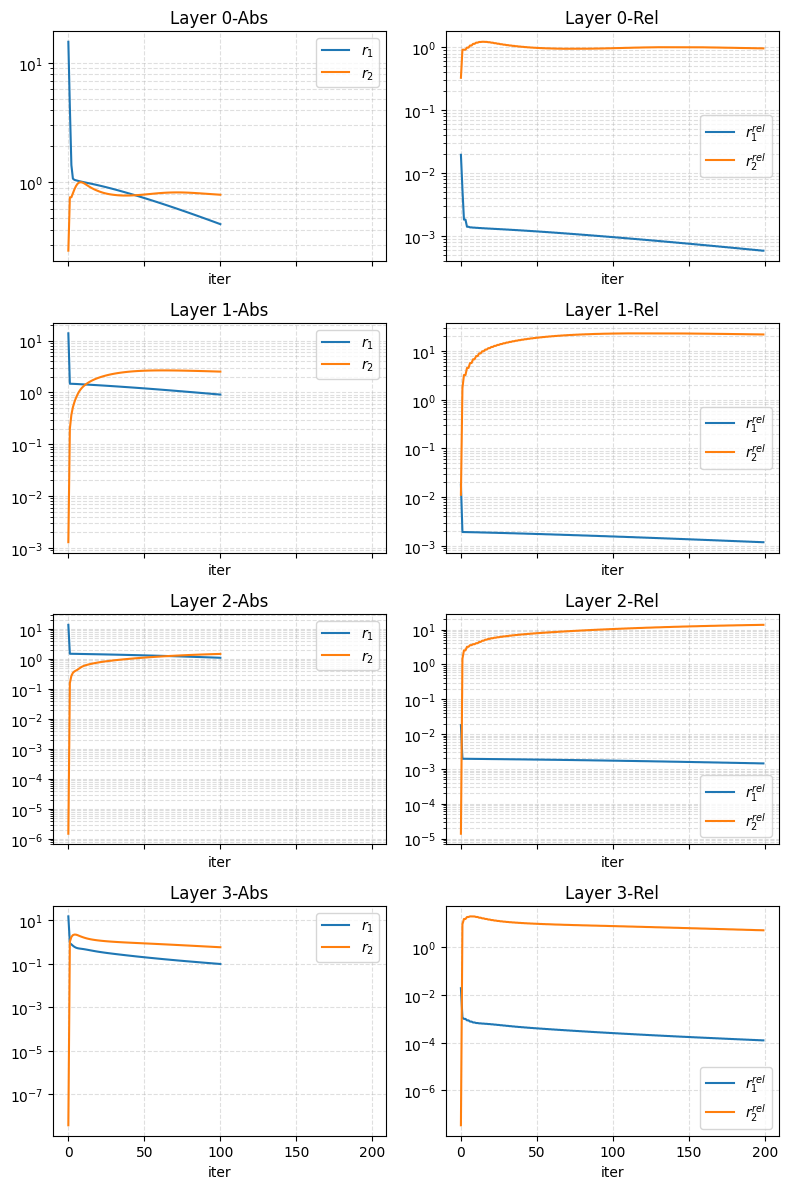

In [5]:
it = 50
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], 
        # "dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1
  layer      W_q_norm      W_k_norm      G_q_norm      G_k_norm    Y_norm
0     0   2937.508789   1028.451172  1.043992e-02  9.099962e-03  1.202436
1     1  26198.033203   9090.496094  2.832912e-05  2.108930e-04  2.369556
2     2   3820.883057   6328.715332  3.152762e-07  7.409079e-07  0.144671
3     3   2342.467041  11799.755859  4.028080e-09  3.178733e-09  0.073913


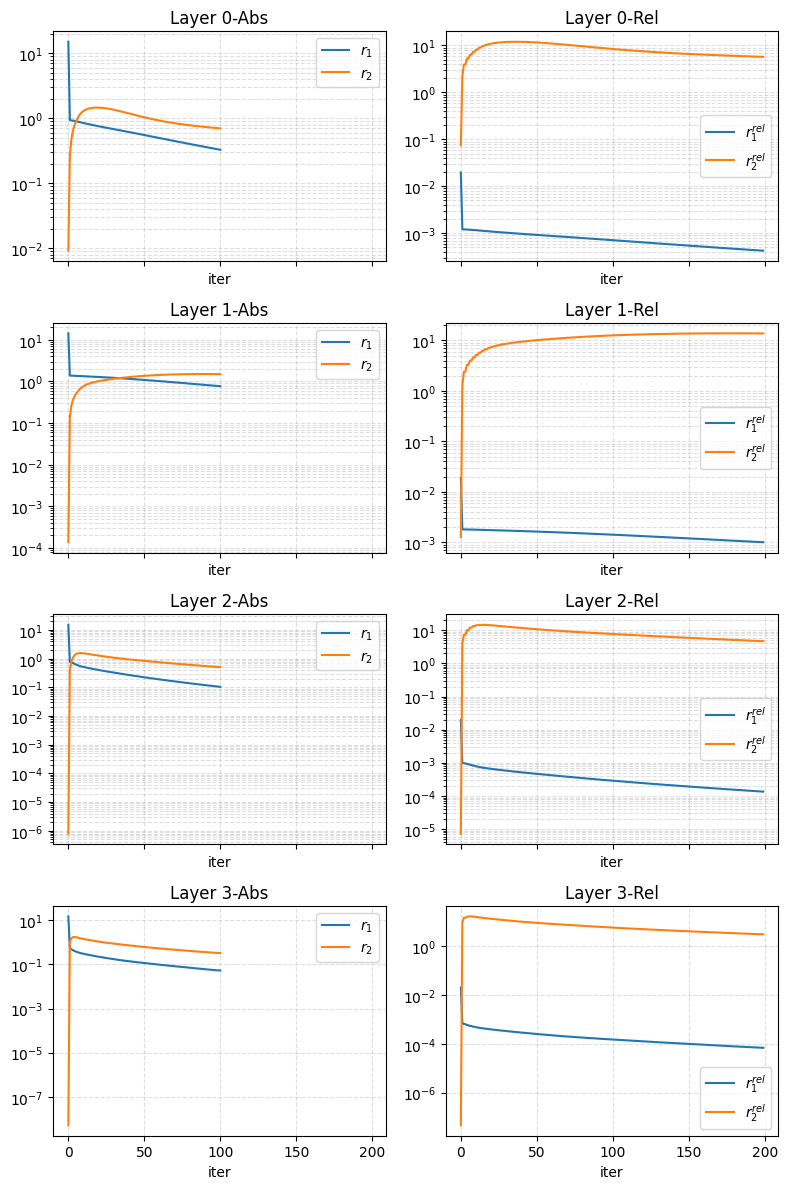

In [6]:
it = -1
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], 
        # "dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)